Time series forecasting. Starting from stocks returns we want to forecast the return using arma model. The returns used are daily. 


In [1]:
import sys
!{sys.executable} -m pip install statsmodels
import sys
!{sys.executable} -m pip install arch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pandas import DataFrame
import scipy.stats as sst
from pandas_datareader import data as pdr
from scipy.stats import norm
from datetime import date
import math
import statsmodels as ss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model



You should consider upgrading via the 'C:\Users\marti\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\marti\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
#asking the user which stock to take
stock = input('What stock should the model be performed on?: ')

What stock should the model be performed on?: AMZN


Here we define the date for the training sample and then for the forecast (in sample training and in sample forecast)

In [3]:
#deciding how big the training sample should be

length_training_sample = int(input('How many days should the training sample be:?'))


end_training = dt.date(2018,1,1)
start_training = end_training - dt.timedelta(days = length_training_sample)

#out of sample forecast dates
start_forecast = end_training + dt.timedelta(days = 1)
end_forecast = date.today()

print('The start of the training is ' + str(start_training) +', the end of the training is ' + str(end_training) +
      ', the start of forecast is ' + str(start_forecast) + ', the end of the forecast is ' + str(end_forecast))

How many days should the training sample be:?4000
The start of the training is 2007-01-19, the end of the training is 2018-01-01, the start of forecast is 2018-01-02, the end of the forecast is 2021-12-05


In [4]:
#downloading the returns for the stock
stock_data = pdr.get_data_yahoo(stock,start_training,end_training)
stock_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2007-01-19,37.480000,36.599998,36.689999,37.020000,6095900,37.020000
2007-01-22,37.900002,36.799999,37.650002,36.950001,8317000,36.950001
2007-01-23,37.070000,36.299999,36.900002,36.430000,5313600,36.430000
2007-01-24,37.360001,36.500000,36.509998,37.259998,5271700,37.259998
2007-01-25,38.230000,36.779999,38.080002,37.080002,6747600,37.080002
...,...,...,...,...,...,...
2017-12-22,1174.619995,1167.829956,1172.079956,1168.359985,1585100,1168.359985
2017-12-26,1178.319946,1160.550049,1168.359985,1176.760010,2005200,1176.760010
2017-12-27,1187.290039,1175.609985,1179.910034,1182.260010,1867200,1182.260010


In [5]:
#keeping only the Close column
stock_data_close = stock_data.Close
stock_data_close


Date
2007-01-19      37.020000
2007-01-22      36.950001
2007-01-23      36.430000
2007-01-24      37.259998
2007-01-25      37.080002
                 ...     
2017-12-22    1168.359985
2017-12-26    1176.760010
2017-12-27    1182.260010
2017-12-28    1186.099976
2017-12-29    1169.469971
Name: Close, Length: 2758, dtype: float64

In [6]:
#features of the returns
stock_data_close.describe()

count    2758.000000
mean      324.336407
std       280.361181
min        35.029999
25%        95.320000
50%       229.385002
75%       398.612503
max      1195.829956
Name: Close, dtype: float64

Here we perform graphical analysis on the stock prices (time series, graph for rolling mean and standard deviation and histogram). The rolling mean and standard deviation can also be used to inspect graphically the stationarity of a process.

How many days for the rolling?30


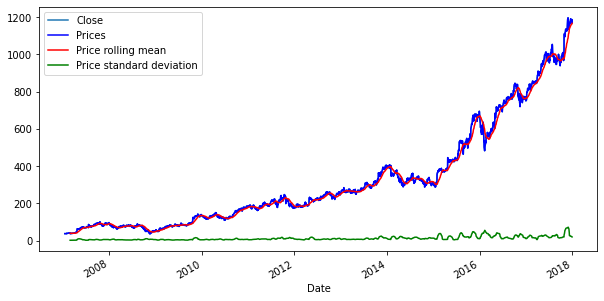

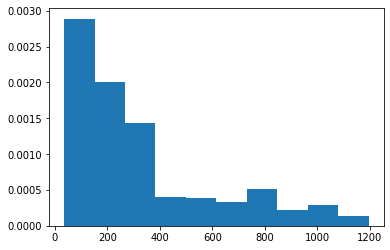

C:\Users\marti\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

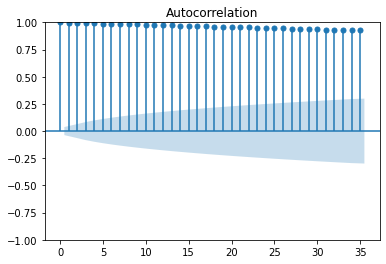

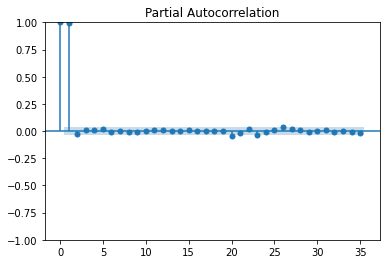

In [7]:
#graph of the prices, with rolling mean and standard deviation and histogram of the prices
window_rolling = int(input('How many days for the rolling?'))
stock_data_close.plot(figsize=(10,5))
rolling_mean_prices = stock_data_close.rolling(window = window_rolling).mean()
rolling_std_prices = stock_data_close.rolling(window = window_rolling).std()
plt.plot(stock_data_close,color ='blue',label ='Prices')
plt.plot(rolling_mean_prices, color = 'red',label='Price rolling mean')
plt.plot(rolling_std_prices,color = 'green',label='Price standard deviation')
plt.legend(loc ='best')
plt.show()
stock_price_hist = plt.hist(stock_data_close,density = True)
plt.show()

#acf and pacf of the prices
plot_acf(stock_data_close)
plot_pacf(stock_data_close)
plt.show

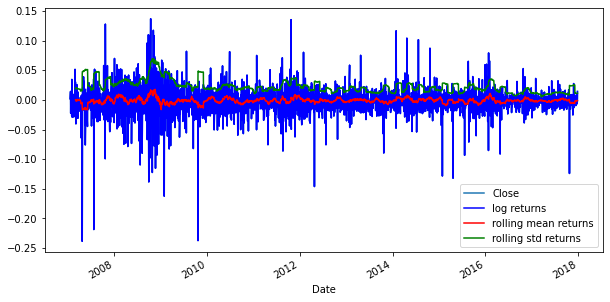

C:\Users\marti\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


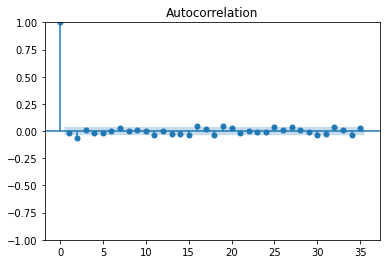

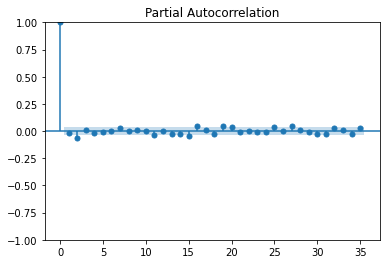

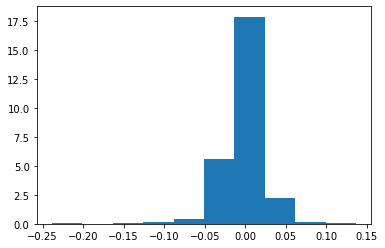

In [8]:
#getting the returns and plotting the returns + acf and pacf
returns = np.log(stock_data_close/stock_data_close.shift(-1))
returns = returns.dropna()
returns 

returns.plot(figsize=(10,5))
rolling_mean_returns = returns.rolling(window = window_rolling).mean()
rolling_std_returns = returns.rolling(window = window_rolling).std()
plt.plot(returns,color = 'blue', label = 'log returns')
plt.plot(rolling_mean_returns, color ='red', label ='rolling mean returns')
plt.plot(rolling_std_returns, color = 'green', label ='rolling std returns')
plt.legend(loc = 'best')
plt.show()

plot_acf(returns)
plot_pacf(returns)
plt.show()
returns_hist = plt.hist(returns,density = True)


In [9]:

#calculating skewness
skewness_returns = sst.skew(returns)

#calculating kurtosis
kurtosis_returns = sst.kurtosis(returns)

print('The skewness of the returns is '+str(skewness_returns) + ' and the kurtosis is '+ str(kurtosis_returns))

The skewness of the returns is -1.0365914289857137 and the kurtosis is 13.020409215141136


In [10]:
#stationarity tests. We perform the following analysis: 
# adf with default number of lags ==> non stationary process as H0 but we cannot say random walk for sure


#adf test
adf_test = ss.tsa.stattools.adfuller(returns,None,'c',None,False,False)

print(' the p value for adf is ' + str(adf_test[1]))


 the p value for adf is 6.7981295046808734e-15


In [11]:
#fitting arima model

returns = returns.asfreq('d')
model_arima = ARIMA(returns,order=(1,0,2))
    

model_fit = model_arima.fit()
model_fit = model_arima.fit()
print(model_fit.summary())



                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3997
Model:                 ARIMA(1, 0, 2)   Log Likelihood                6282.799
Date:                Sun, 05 Dec 2021   AIC                         -12555.599
Time:                        23:20:05   BIC                         -12524.132
Sample:                    01-19-2007   HQIC                        -12544.444
                         - 12-28-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.000     -2.613      0.009      -0.002      -0.000
ar.L1         -0.1052      0.306     -0.343      0.731      -0.705       0.495
ma.L1          0.1159      0.308      0.377      0.7

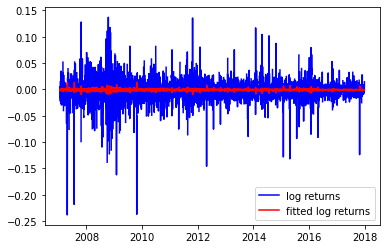

In [12]:
plt.plot(returns,color='blue',label ='log returns')
plt.plot(model_fit.fittedvalues, color = 'red', label = 'fitted log returns')
plt.legend(loc ='best')
plt.show()


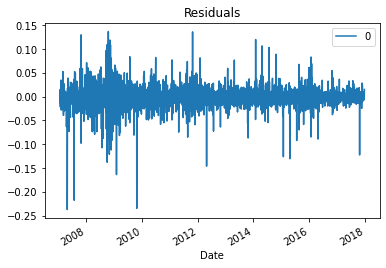

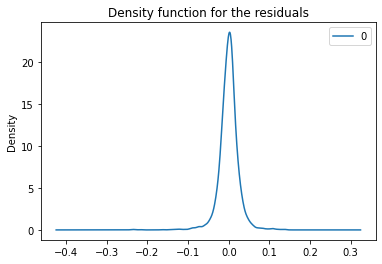

In [13]:
#residuals from the model
residuals_arima = DataFrame(model_fit.resid.dropna())

residuals_arima.plot()
plt.title('Residuals')
plt.show()

residuals_arima.plot(kind ='kde')
plt.title('Density function for the residuals')
plt.show()



C:\Users\marti\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


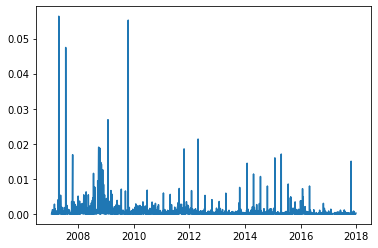

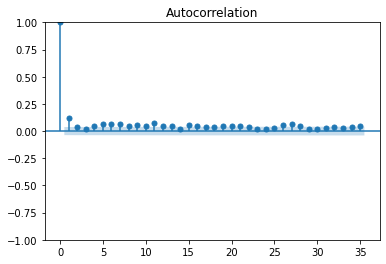

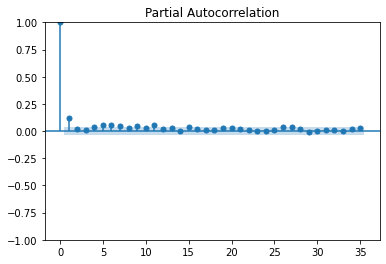

In [14]:
#fitting garch model
#we first check the acf and pacf of residuals

residuals_squared = residuals_arima **2
plt.plot(residuals_squared)
plot_acf(residuals_squared)
plot_pacf(residuals_squared)
plt.show()




In [18]:
#garch model estimation
garch_model = arch_model(residuals_arima, vol='Garch', p=1, o=0, q=1)
garch_fitted = garch_model.fit()
print(garch_fitted.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 23542671502.308666
Iteration:      2,   Func. Count:     18,   Neg. LLF: -3454.8613225402223
Iteration:      3,   Func. Count:     28,   Neg. LLF: -5918.008524151929
Iteration:      4,   Func. Count:     35,   Neg. LLF: -6185.9526490675125
Iteration:      5,   Func. Count:     42,   Neg. LLF: -6425.043977461488
Iteration:      6,   Func. Count:     48,   Neg. LLF: -6421.585379301254
Iteration:      7,   Func. Count:     54,   Neg. LLF: -6437.867343266652
Iteration:      8,   Func. Count:     60,   Neg. LLF: -6456.440565564812
Iteration:      9,   Func. Count:     65,   Neg. LLF: -6456.448840873254
Iteration:     10,   Func. Count:     70,   Neg. LLF: -6456.449052878762
Iteration:     11,   Func. Count:     75,   Neg. LLF: -6456.449115090996
Iteration:     12,   Func. Count:     79,   Neg. LLF: -6456.449115090693
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6456.449115090996
            I

C:\Users\marti\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000614. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
